### Importing libraries and packages

In [89]:
# Import libraries for our task
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

import numpy as np
import pandas as pd
import seaborn as sns 
import mlflow
import matplotlib.pyplot as plt


In [90]:
# Import system libraries and our Scripts

import os
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('../script')))

In [91]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [92]:
# Read AdSmart_AB_testing_data 
# Import system libraries and our Scripts

data  = pd.read_csv(r'C:\Users\ende\Desktop\abtest-mlops\data\AdSmart_AB_testing_data.csv')

## Exploring data

In [93]:
# The types and shape of data features in the dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [94]:
print(f" There are {data.shape[0]} rows and {data.shape[1]} columns")

 There are 8077 rows and 9 columns


In [95]:
data.head(4)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0


In [96]:
data.isnull().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

In [97]:
# Information about the numeric data

data.describe()

,hour,platform_os,yes,no
count,8077.00,8077.00,8077.00,8077.00
mean,11.62,5.95,0.07,0.08
std,5.73,0.22,0.26,0.28
min,0.00,5.00,0.00,0.00
25%,7.00,6.00,0.00,0.00
50%,13.00,6.00,0.00,0.00
75%,15.00,6.00,0.00,0.00
max,23.00,7.00,1.00,1.00


In [98]:
data['auction_id'].nunique()

8077

In [99]:
data['experiment'].value_counts()

control    4071
exposed    4006
Name: experiment, dtype: int64

In [100]:
data['yes'].value_counts()

0    7505
1     572
Name: yes, dtype: int64

In [101]:
data['no'].value_counts()

0    7406
1     671
Name: no, dtype: int64

<AxesSubplot:ylabel='None'>

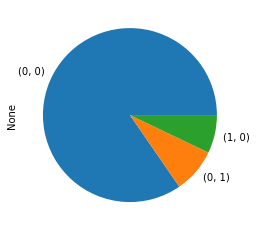

In [102]:
data[['yes','no']].value_counts().plot(kind='pie')

In [103]:
data.groupby(['experiment']).count()

,auction_id,date,hour,device_make,platform_os,browser,yes,no
experiment,,,,,,,,
control,4071,4071,4071,4071,4071,4071,4071,4071
exposed,4006,4006,4006,4006,4006,4006,4006,4006


Since we have users who donot respond to the experiment let us remove them from our dataframe.

In [104]:
def delete_no_respond_users(df):
    cleaned_df = df.query("not (yes == 0 & no == 0)")
    return cleaned_df
    
clean_df = delete_no_respond_users(data)

In [105]:
clean_df.groupby(['experiment']).count()

,auction_id,date,hour,device_make,platform_os,browser,yes,no
experiment,,,,,,,,
control,586,586,586,586,586,586,586,586
exposed,657,657,657,657,657,657,657,657


<AxesSubplot:title={'center':'Total number of users who said Yes and No'}, xlabel='yes,no'>

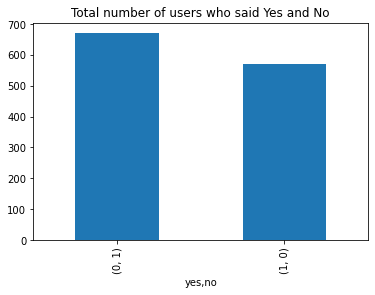

In [106]:
clean_df[['yes','no']].value_counts().plot(kind='bar', title="Total number of users who said Yes and No")

<AxesSubplot:title={'center':'Users who said Yes'}, xlabel='experiment'>

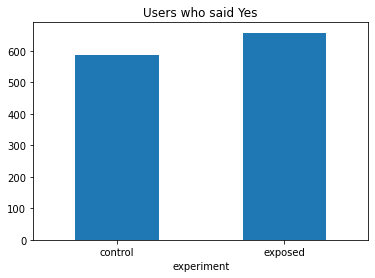

In [107]:
clean_df.groupby('experiment').count()['yes'].plot.bar(rot=0, title="Users who said Yes")

<AxesSubplot:title={'center':'Users who said No'}, xlabel='experiment'>

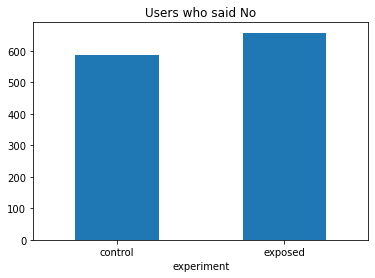

In [108]:
clean_df.groupby('experiment').count()['no'].plot.bar(rot=0, title="Users who said No")

In [109]:
clean_df.groupby(['experiment']).count()

,auction_id,date,hour,device_make,platform_os,browser,yes,no
experiment,,,,,,,,
control,586,586,586,586,586,586,586,586
exposed,657,657,657,657,657,657,657,657


In [110]:
indexNames = clean_df[(data['yes'] == 0) & (data['no'] == 0)].index
# Delete these row indexes from dataFrame
clean_df.drop(indexNames , inplace=True)

In [111]:
clean_df.groupby(['experiment']).count()

,auction_id,date,hour,device_make,platform_os,browser,yes,no
experiment,,,,,,,,
control,586,586,586,586,586,586,586,586
exposed,657,657,657,657,657,657,657,657


<AxesSubplot:xlabel='yes,no'>

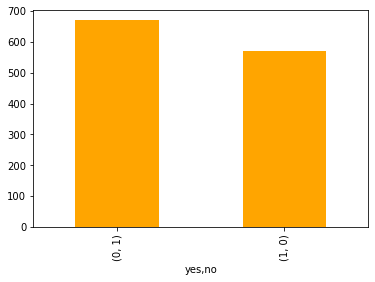

In [112]:
clean_df[['yes','no']].value_counts().plot(kind='bar',color='orange')

#### Data Transformation

Map *yes* to *aware* column and remove *yes* and *no*

In [113]:
clean_df['aware'] = clean_df['yes'].map(lambda x: x==1)
clean_df = clean_df.drop(columns = ['yes', 'no'], axis=1)
clean_df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,aware
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,False
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,True
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,False
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,True
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,False


In [114]:
# Encode aware to 0 and 1
clean_df['aware'] = clean_df['aware'].astype(int)

In [115]:
from sklearn.preprocessing import LabelEncoder
# change categorical variables to numerical value
lb = LabelEncoder()
clean_df['experiment'] = lb.fit_transform(clean_df['experiment'])
clean_df['browser'] = lb.fit_transform(clean_df['browser'])
clean_df['device_make'] = lb.fit_transform(clean_df['device_make'])
clean_df['date'] = lb.fit_transform(clean_df['date'])
clean_df['aware'] = lb.fit_transform(clean_df['aware'])


Model training 

In [116]:
# feature_cols = ["experiment", "hour", "date", 'device_make', "platform_os",  "browser"]
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = clean_df[feature_cols]
y = clean_df[['aware']]

test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [117]:
# Define Random Forest Model
rf = RandomForestClassifier(n_estimators=100)

# We fit our model with our train data
rf.fit(X_train, y_train)

# Then predict results from X_test data
pred_rf = rf.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_rf[0:10])
print("Actual:", y_test[0:10])

2022/05/20 03:37:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID c490675b422e4fe6b2b449e591003eef. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'criterion\' was already logged with value=\'mse\' for run ID=\'c490675b422e4fe6b2b449e591003eef\'. Attempted logging new value \'gini\'.")]')]


Predicted: [0 1 0 0 1 0 1 0 0 1]
Actual:       aware
5938      1
6661      0
4579      0
4243      0
6058      1
6629      0
5037      1
6138      1
3131      0
3036      1


In [118]:
# Define Decision Tree Model
dt = DecisionTreeClassifier()
# We fit our model with our train data
dt.fit(X_train, y_train)
# Then predict results from X_test data
pred_dt = dt.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_dt[0:10])
print("Actual:", y_test[0:10])

2022/05/20 03:37:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID c490675b422e4fe6b2b449e591003eef. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'criterion\' was already logged with value=\'mse\' for run ID=\'c490675b422e4fe6b2b449e591003eef\'. Attempted logging new value \'gini\'.")]')]


Predicted: [0 0 0 0 1 0 1 0 0 0]
Actual:       aware
5938      1
6661      0
4579      0
4243      0
6058      1
6629      0
5037      1
6138      1
3131      0
3036      1


In [119]:
# Define Logistic Regression Model
log = LogisticRegression()
# We fit our model with our train data
log.fit(X_train, y_train)
# Then predict results from X_test data
pred_log = log.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_log[0:10])
print("Actual:", y_test[0:10])

Predicted: [0 1 0 0 1 0 1 0 0 0]
Actual:       aware
5938      1
6661      0
4579      0
4243      0
6058      1
6629      0
5037      1
6138      1
3131      0
3036      1


In [120]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB
# Define Bernouilli Naive Bias Model
bnb = BernoulliNB()
# We fit our model with our train data
bnb.fit(X_train, y_train)
# Then predict results from X_test data
pred_bnb = bnb.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_bnb[0:10])
print("Actual:", y_test[0:10])

Predicted: [1 0 0 0 0 0 0 0 0 0]
Actual:       aware
5938      1
6661      0
4579      0
4243      0
6058      1
6629      0
5037      1
6138      1
3131      0
3036      1


In [121]:
# Define Gaussian Naive Bias Model
gnb = GaussianNB()
# We fit our model with our train data
gnb.fit(X_train, y_train)
# Then predict results from X_test data
pred_gnb = gnb.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_gnb[0:10])
print("Actual:", y_test[0:10])

Predicted: [0 1 0 0 1 0 1 1 0 0]
Actual:       aware
5938      1
6661      0
4579      0
4243      0
6058      1
6629      0
5037      1
6138      1
3131      0
3036      1


In [122]:
from sklearn.neighbors import KNeighborsClassifier
# Define KNN Model
knn = KNeighborsClassifier(n_neighbors=3, metric="minkowski")
# We fit our model with our train data
knn.fit(X_train, y_train)
# Then predict results from X_test data
pred_knn = knn.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_knn[0:10])
print("Actual:", y_test[0:10])

Predicted: [0 0 1 0 1 0 1 0 1 1]
Actual:       aware
5938      1
6661      0
4579      0
4243      0
6058      1
6629      0
5037      1
6138      1
3131      0
3036      1


In [123]:
from xgboost import XGBClassifier
# Define XGBoost Model
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
# We fit our model with our train data
xgb.fit(
    X_train, y_train,
    # That means if model don't improve it self in 5 rounds, it will stop learning
    # So you can save your time and don't overtrain your model.
    early_stopping_rounds=5,
    # We provide Test data's to evaluate model performance
    eval_set=[(X_test, y_test)],
    verbose=False
 )
# Then predict results from X_test data
pred_xgb = xgb.predict(X_test)

# See First 10 Predictions and They Actual Values
# print("Predicted:", pred_xgb[0:10])
print("Actual:", y_test[0:10])

2022/05/20 03:38:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID c490675b422e4fe6b2b449e591003eef. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'6\' for run ID=\'c490675b422e4fe6b2b449e591003eef\'. Attempted logging new value \'None\'.")]')]


Actual:       aware
5938      1
6661      0
4579      0
4243      0
6058      1
6629      0
5037      1
6138      1
3131      0
3036      1


In [124]:
# Confusion Matrixes
# First parameter is actual value
# second parameter is value that we prediceted
from sklearn.metrics import accuracy_score, confusion_matrix
# Random Forest 
cm_rf = confusion_matrix(y_test, pred_rf)
# Desicion Tree
cm_dt = confusion_matrix(y_test, pred_dt)
# Logistic Regression
cm_log = confusion_matrix(y_test, pred_log)
# Bernouilli Naive Bias
cm_bnb = confusion_matrix(y_test, pred_bnb)
# Gaussian Naive Bias
cm_gnb = confusion_matrix(y_test, pred_gnb)
# KNN (K-Nearest Neighbors)
cm_knn = confusion_matrix(y_test, pred_knn)
# XGBoost 
cm_xgb = confusion_matrix(y_test, pred_xgb)

print("***********************")
print("Confusion Matrixes")
print("***********************")
print("Random Forest:\n", cm_rf)
print("Desicion Tree:\n", cm_dt)
print("Logistic Regression:\n", cm_log)
print("Bernouilli Naive Bias:\n", cm_bnb)
print("Gaussian Naive Bias:\n", cm_gnb)
print("KNN (K-Nearest Neighbors):\n", cm_knn)
print("XGBoost:\n", cm_xgb)

***********************
Confusion Matrixes
***********************
Random Forest:
 [[135  66]
 [ 97  75]]
Desicion Tree:
 [[131  70]
 [109  63]]
Logistic Regression:
 [[173  28]
 [145  27]]
Bernouilli Naive Bias:
 [[197   4]
 [167   5]]
Gaussian Naive Bias:
 [[165  36]
 [127  45]]
KNN (K-Nearest Neighbors):
 [[100 101]
 [ 99  73]]
XGBoost:
 [[166  35]
 [127  45]]


In [125]:
# Accuracy Scores
# First parameter is actual value
# second parameter is value that we prediceted

# Random Forest 
acc_rf = accuracy_score(y_test, pred_rf)
# Desicion Tree
acc_dt = accuracy_score(y_test, pred_dt)
# Logistic Regression
acc_log = accuracy_score(y_test, pred_log)
# Bernouilli Naive Bias
acc_bnb = accuracy_score(y_test, pred_bnb)
# Gaussian Naive Bias
acc_gnb = accuracy_score(y_test, pred_gnb)
# KNN (K-Nearest Neighbors)
acc_knn = accuracy_score(y_test, pred_knn)
# XGBoost 
acc_xgb = accuracy_score(y_test, pred_xgb)

print("***********************")
print("Accuracy Scores")
print("***********************")
print("Random Forest:", acc_rf)
print("Desicion Tree:", acc_dt)
print("Logistic Regression:", acc_log)
print("Bernouilli Naive Bias:", acc_bnb)
print("Gaussian Naive Bias:", acc_gnb)
print("KNN (K-Nearest Neighbors):", acc_knn)
print("XGBoost:", acc_xgb)

***********************
Accuracy Scores
***********************
Random Forest: 0.5630026809651475
Desicion Tree: 0.5201072386058981
Logistic Regression: 0.5361930294906166
Bernouilli Naive Bias: 0.5415549597855228
Gaussian Naive Bias: 0.5630026809651475
KNN (K-Nearest Neighbors): 0.46380697050938335
XGBoost: 0.5656836461126006


### SKlearn pipeline

In [126]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
         plt.tight_layout()
         plt.ylabel('True label')
         plt.xlabel('Predicted label')

In [127]:
pipelin=Pipeline([('scalar1',StandardScaler()),
                     ('pca1',PCA(n_components=2)),
                     ('lr_classifier',LogisticRegression(random_state=0))])

In [128]:
pipedes=Pipeline([('scalar2',StandardScaler()),
                     ('pca2',PCA(n_components=2)),
                     ('dt_classifier',DecisionTreeClassifier())])

In [129]:
piperan=Pipeline([('scalar3',StandardScaler()),
                     ('pca3',PCA(n_components=2)),
                     ('rf_classifier',RandomForestClassifier())])

In [130]:
pipeber=Pipeline([('scalar3',StandardScaler()),
                     ('pca3',PCA(n_components=2)),
                     ('rf_classifier',BernoulliNB())])

In [131]:
pipexgb=Pipeline([('scalar3',StandardScaler()),
                     ('pca3',PCA(n_components=2)),
                     ('rf_classifier',XGBClassifier())])

In [132]:
pipekn=Pipeline([('scalar3',StandardScaler()),
                     ('pca3',PCA(n_components=2)),
                     ('rf_classifier',KNeighborsClassifier())])

In [133]:
pipexg=Pipeline([('scalar3',StandardScaler()),
                     ('pca3',PCA(n_components=2)),
                     ('rf_classifier',XGBClassifier())])

In [134]:
## LEts make the list of pipelines
pipelines = [pipelin, pipedes, piperan,pipeber,pipexgb,pipekn,pipexg]

In [135]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest',3:'Bernouilli Naive Bias',4:'Gaussian Naive Bias',5:'KNN',6:'XGBoost'}

# Fit the pipelines
for pipe in pipelines:
	pipe.fit(X_train, y_train)

2022/05/20 03:39:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID c490675b422e4fe6b2b449e591003eef. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'verbose\' was already logged with value=\'0\' for run ID=\'c490675b422e4fe6b2b449e591003eef\'. Attempted logging new value \'False\'.")]')]
2022/05/20 03:39:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID c490675b422e4fe6b2b449e591003eef. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'scalar1\', S

In [136]:
for i,model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i],model.score(X_test,y_test)))

Logistic Regression Test Accuracy: 0.5388739946380697
Decision Tree Test Accuracy: 0.5442359249329759
RandomForest Test Accuracy: 0.5817694369973191
Bernouilli Naive Bias Test Accuracy: 0.5388739946380697
Gaussian Naive Bias Test Accuracy: 0.5335120643431636
KNN Test Accuracy: 0.5308310991957105
XGBoost Test Accuracy: 0.5335120643431636


In [137]:
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [138]:
for i,model in enumerate(pipelines):
    if model.score(X_test,y_test)>best_accuracy:
        best_accuracy=model.score(X_test,y_test)
        best_pipeline=model
        best_classifier=i
    
print('Classifier with best accuracy:{}'.format(pipe_dict[best_classifier]))

Classifier with best accuracy:RandomForest


In [139]:
import pickle
model=RandomForestClassifier()
model.fit(X_train, y_train)
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

2022/05/20 03:41:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID c490675b422e4fe6b2b449e591003eef. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'criterion\' was already logged with value=\'mse\' for run ID=\'c490675b422e4fe6b2b449e591003eef\'. Attempted logging new value \'gini\'.")]')]


In [140]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.5710455764075067


2022/05/20 03:41:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID c490675b422e4fe6b2b449e591003eef. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'scalar1\', StandardScaler()), (\'pca1\', PCA(n_components=2)), (\'lr_classifier\', LogisticRegression(random_state=0))]\' for run ID=\'c490675b422e4fe6b2b449e591003eef\'. Attempted logging new value \'[(\'model\', LogisticRegression(random_state=0))]\'.")]')]


accuracy: 53.62%
Confusion matrix, without normalization


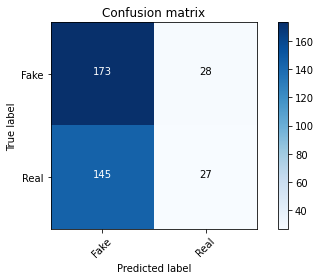

In [141]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('model', LogisticRegression(random_state=0))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

2022/05/20 03:42:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID c490675b422e4fe6b2b449e591003eef. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'steps\' was already logged with value=\'[(\'scalar1\', StandardScaler()), (\'pca1\', PCA(n_components=2)), (\'lr_classifier\', LogisticRegression(random_state=0))]\' for run ID=\'c490675b422e4fe6b2b449e591003eef\'. Attempted logging new value \'[(\'model\', RandomForestClassifier())]\'.")]')]


accuracy: 54.96%
Confusion matrix, without normalization


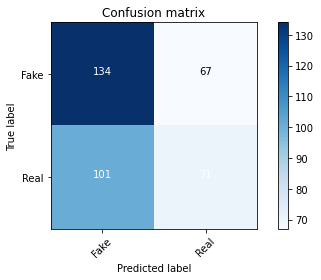

In [142]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('model', RandomForestClassifier())])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [143]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('model', DecisionTreeClassifier())])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Yes', 'No'])

In [ ]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('model', BernoulliNB())])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Yes', 'No'])

In [ ]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('model', GaussianNB())])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Yes', 'No'])

In [ ]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('model', XGBClassifier())])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [ ]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('model', KNeighborsClassifier())])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [ ]:
plt.barh(feature_cols, rf.feature_importances_,color='purple')


Based on the feature importance calculation of our ml model we can conclude that device make and hour has a vital role on brand awareness


Separating data in two platform and browser datasets

In [ ]:
import mlflow

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

mlflow.autolog()

brw = clean_df[["experiment", "hour", "date", 'device_make', 'browser', 'aware']]

data1=brw.to_csv(r"C:\Users\ende\Desktop\abtest-mlops\data\brw.csv")  
plat = clean_df[["experiment", "hour", "date", 'device_make', 'platform_os', 'aware']]




The datasets of browser and platform  are saved as version two and version three respectively on dvc

In [ ]:
#trainig the browser dataset
x=brw[["experiment", "hour", "date", "device_make", "browser"]]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(x, brw.aware,test_size=0.3,random_state=45)


In [ ]:
#calling the algorithems to check their respective performace
rf = RandomForestRegressor(n_estimators = 100, max_depth = 6, max_features = 3)
rf.fit(X_train, y_train)

# Use the model to make predictions on the test dataset.
predictions = rf.predict(X_test)
autolog_run = mlflow.last_active_run()
sk_model=rf
sk_path_dir_2 = r'C:\Users\ende\Desktop\abtest-mlops\models'
mlflow.sklearn.save_model(sk_model,sk_path_dir_2,serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE)

In [ ]:
#calling the logistic to check their respective performace
lg = LogisticRegression()
rf.fit(X_train, y_train)

# Use the model to make predictions on the test dataset.
predictions = lg.predict(X_test)
autolog_run = mlflow.last_active_run()
sk_model=rf
sk_path_dir_2 = r'C:\Users\ende\Desktop\abtest-mlops\models'
mlflow.sklearn.save_model(sk_model,sk_path_dir_2,serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE)


In [ ]:
#calling the logistic to check their respective performace
kn = KNeighborsClassifier()
rf.fit(X_train, y_train)

# Use the model to make predictions on the test dataset.
predictions = kn.predict(X_test)
autolog_run = mlflow.last_active_run()
sk_model=rf
sk_path_dir_2 = r'C:\Users\ende\Desktop\abtest-mlops\models'
mlflow.sklearn.save_model(sk_model,sk_path_dir_2,serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE)



In [ ]:
#saving the best perfomer model
modelpath = "/dbfs/my_project_models/model-%f-%f" % (alpha, l1_ratio)
  mlflow.sklearn.save_model(lr, modelpath)

In [ ]:
#trainig the platform dataset
x=plt[["experiment", "hour", "date", "device_make", "platform_os"]]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(x, plt.aware,test_size=0.3,random_state=45)



In [ ]:
#calling the algorithems to check their respective performace
rf = RandomForestRegressor(n_estimators = 100, max_depth = 6, max_features = 3)
rf.fit(X_train, y_train)

# Use the model to make predictions on the test dataset.
predictions = rf.predict(X_test)
autolog_run = mlflow.last_active_run()
sk_model=rf
sk_path_dir_2 = r'C:\Users\ende\Desktop\abtest-mlops\models'
mlflow.sklearn.save_model(sk_model,sk_path_dir_2,serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE)

In [ ]:
#calling the logistic to check their respective performace
lg = LogisticRegression()
rf.fit(X_train, y_train)

# Use the model to make predictions on the test dataset.
predictions = lg.predict(X_test)
autolog_run = mlflow.last_active_run()
sk_model=rf
sk_path_dir_2 = r'C:\Users\ende\Desktop\abtest-mlops\models'
mlflow.sklearn.save_model(sk_model,sk_path_dir_2,serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE)


In [ ]:
#calling the logistic to check their respective performace
kn = KNeighborsClassifier()
rf.fit(X_train, y_train)

# Use the model to make predictions on the test dataset.
predictions = kn.predict(X_test)
autolog_run = mlflow.last_active_run()
sk_model=rf
sk_path_dir_2 = r'C:\Users\ende\Desktop\abtest-mlops\models'
mlflow.sklearn.save_model(sk_model,sk_path_dir_2,serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE)



In [ ]:
#saving the best perfomer model
modelpath = "/dbfs/my_project_models/model-%f-%f" % (alpha, l1_ratio)
  mlflow.sklearn.save_model(lr, modelpath)